## 03_analysis_m
  
Mourad Askar

**An in depth dive into the data in order to understand it**  
 
* Categorical variables distribution investigation
* Crash Injury Patterns Visualizations
    * Time of Day
    * Day of Week
    * Geographically

In [1]:
import pandas as pd
import numpy as np
import klib
import pandas_profiling as pp
import sweetviz
import sklearn

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from platform import python_version

%precision 2

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120
pd.options.display.float_format='{:,.2f}'.format
pd.options.display.precision = 2

np.set_printoptions(precision=4, linewidth=120, suppress=True, edgeitems=5)

sns.set_style("white")

print('python',python_version())
print(np.__name__, np.__version__)
print(pd.__name__, pd.__version__)
print(klib.__name__, klib.__version__)
#print(pp.__name__, pp.__version__)
print(sklearn.__name__, sklearn.__version__)
print(sweetviz.__name__, sweetviz.__version__)

python 3.9.2
numpy 1.20.1
pandas 1.1.4
klib 0.1.5
sklearn 0.24.1
sweetviz 2.0.9


# Read Data

In [2]:
#file_parquet_c = '20210203_chi_crashes_c.parquet'
#file_parquet_c = '20210228_chi_crashes_c.parquet'
file_crash_df_parquet = 'crash_df.parquet'

crash_df = pd.read_parquet(file_crash_df_parquet)

crash_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 478484 entries, 0 to 481622
Data columns (total 29 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   crash_date               478484 non-null  datetime64[ns]
 1   crash_year               478484 non-null  int16         
 2   crash_month              478484 non-null  int8          
 3   crash_day_of_week        478484 non-null  int8          
 4   crash_hour               478484 non-null  int8          
 5   crash_time_of_day        478484 non-null  category      
 6   latitude                 478484 non-null  float32       
 7   longitude                478484 non-null  float32       
 8   beat_of_occurrence       478484 non-null  int64         
 9   address                  478484 non-null  string        
 10  posted_speed_limit       478484 non-null  int64         
 11  traffic_control_device   478484 non-null  category      
 12  device_condition

In [3]:
crash_df = crash_df[(crash_df.crash_year>2017) & (crash_df.crash_year<2021)]

In [4]:
[*crash_df.columns]

['crash_date',
 'crash_year',
 'crash_month',
 'crash_day_of_week',
 'crash_hour',
 'crash_time_of_day',
 'latitude',
 'longitude',
 'beat_of_occurrence',
 'address',
 'posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'trafficway_type',
 'alignment',
 'roadway_surface_cond',
 'road_defect',
 'first_crash_type',
 'prim_contributory_cause',
 'sec_contributory_cause',
 'num_units',
 'has_injuries',
 'has_fatal',
 'crash_type',
 'damage',
 'injuries_total',
 'injuries_fatal']

In [5]:
features_names = [
    'crash_date',
    'crash_year',
    'crash_month',
    'crash_day_of_week',
    'crash_hour',
    'crash_time_of_day', # New
    'latitude',
    'longitude',
    'beat_of_occurrence',
    'address',
#    'street_no',
#    'street_direction',
#    'street_name',
    'posted_speed_limit',
    'traffic_control_device',
    'device_condition',
    'weather_condition',
    'lighting_condition',
    'trafficway_type',
    'alignment',
    'roadway_surface_cond',
    'road_defect',
    'first_crash_type',
    'prim_contributory_cause',
    'sec_contributory_cause',
    'num_units',
#    'intersection_related_i',
#    'not_right_of_way_i',
#    'hit_and_run_i',
]

target_names = [
    'has_injuries',  # New
    'has_fatal',  # New
    'crash_type',
    'damage',
    'injuries_total',
    'injuries_fatal',
#    'injuries_incapacitating',
#    'inj_non_incap',
#    'inj_report_not_evdnt',
#    'injuries_no_indication',
#    'most_severe_injury',
]

all_columns = features_names + target_names
all_columns

['crash_date',
 'crash_year',
 'crash_month',
 'crash_day_of_week',
 'crash_hour',
 'crash_time_of_day',
 'latitude',
 'longitude',
 'beat_of_occurrence',
 'address',
 'posted_speed_limit',
 'traffic_control_device',
 'device_condition',
 'weather_condition',
 'lighting_condition',
 'trafficway_type',
 'alignment',
 'roadway_surface_cond',
 'road_defect',
 'first_crash_type',
 'prim_contributory_cause',
 'sec_contributory_cause',
 'num_units',
 'has_injuries',
 'has_fatal',
 'crash_type',
 'damage',
 'injuries_total',
 'injuries_fatal']

In [6]:
crash_df.posted_speed_limit.value_counts()

30    240534
35     23062
25     20288
20     12900
15     11671
10      7132
0       3224
40      3101
5       2312
45      1871
55       241
50        72
60        12
65         5
70         3
Name: posted_speed_limit, dtype: int64

In [7]:
crash_df.posted_speed_limit.round(-1).value_counts() # rounding down to nearest 10

30    240534
20     44859
40     28034
10      7132
0       5536
60       258
50        72
70         3
Name: posted_speed_limit, dtype: int64

In [8]:
crash_df.posted_speed_limit.apply(lambda x: (x//10*10) + round(x%10/10)*10).value_counts() # rounding at mid-point to nearest 10

30    263596
20     33188
10     18803
0       5536
40      4972
50       313
60        17
70         3
Name: posted_speed_limit, dtype: int64

In [9]:
crash_df.posted_speed_limit.apply(lambda x: (x//5*5) + round(x%5/5)*5).value_counts() # rounding to nearest 5

30    240534
35     23062
25     20288
20     12900
15     11671
10      7132
0       3224
40      3101
5       2312
45      1871
55       241
50        72
60        12
65         5
70         3
Name: posted_speed_limit, dtype: int64

In [10]:
(lambda x: (x//10*10) + round(x%10/10)*10)(6) # Testing rounding formula

10

In [11]:
crash_df.beat_of_occurrence.nunique()

271

In [12]:
crash_df.address.nunique()

170681

In [13]:
crash_df.groupby(['latitude','longitude']).size().reset_index(name='n')

latitude  longitude  n
0          41.64     -87.54  6
1          41.64     -87.62  1
2          41.64     -87.62  4
3          41.64     -87.62  2
4          41.64     -87.61  1
...          ...        ... ..
162700     42.02     -87.68  1
162701     42.02     -87.67  1
162702     42.02     -87.67  1
162703     42.02     -87.67  1
162704     42.02     -87.67  3

[162705 rows x 3 columns]

In [14]:
#crash_df.most_severe_injury.value_counts()

In [15]:
crash_df.crash_type.value_counts()

NO INJURY / DRIVE AWAY              235435
INJURY AND / OR TOW DUE TO CRASH     90993
Name: crash_type, dtype: int64

In [16]:
crash_df.injuries_total.apply(lambda x: int(x>0)).value_counts()

0    279647
1     46781
Name: injuries_total, dtype: int64

In [17]:
crash_df.injuries_fatal.apply(lambda x: int(x>0)).value_counts()

0    326073
1       355
Name: injuries_fatal, dtype: int64

In [18]:
crash_df.first_crash_type.value_counts()

PARKED MOTOR VEHICLE            75266
REAR END                        74328
SIDESWIPE SAME DIRECTION        48195
TURNING                         46814
ANGLE                           34934
FIXED OBJECT                    16274
PEDESTRIAN                       8528
PEDALCYCLIST                     5157
SIDESWIPE OPPOSITE DIRECTION     4701
OTHER OBJECT                     3354
HEAD ON                          2738
REAR TO FRONT                    2470
REAR TO SIDE                     1539
OTHER NONCOLLISION               1120
REAR TO REAR                      560
ANIMAL                            242
OVERTURNED                        185
TRAIN                              23
Name: first_crash_type, dtype: int64

In [19]:
crash_df.trafficway_type.value_counts()

NOT DIVIDED                        146282
DIVIDED - W/MEDIAN (NOT RAISED)     55308
ONE-WAY                             42340
PARKING LOT                         22136
DIVIDED - W/MEDIAN BARRIER          19167
FOUR WAY                            13787
OTHER                                8750
ALLEY                                5503
UNKNOWN                              3126
CENTER TURN LANE                     2897
T-INTERSECTION                       2896
DRIVEWAY                             1131
RAMP                                 1028
UNKNOWN INTERSECTION TYPE             872
Y-INTERSECTION                        354
FIVE POINT, OR MORE                   351
TRAFFIC ROUTE                         259
NOT REPORTED                          109
ROUNDABOUT                             85
L-INTERSECTION                         47
Name: trafficway_type, dtype: int64

In [20]:
crash_df.prim_contributory_cause.value_counts()

UNABLE TO DETERMINE                                                                 119773
FAILING TO YIELD RIGHT-OF-WAY                                                        36504
FOLLOWING TOO CLOSELY                                                                32816
NOT APPLICABLE                                                                       17705
FAILING TO REDUCE SPEED TO AVOID CRASH                                               15362
IMPROPER OVERTAKING/PASSING                                                          15270
IMPROPER BACKING                                                                     13816
IMPROPER LANE USAGE                                                                  12358
IMPROPER TURNING/NO SIGNAL                                                           11089
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                   9902
DISREGARDING TRAFFIC SIGNALS                                                          6599

In [21]:
crash_df.sec_contributory_cause.value_counts()

NOT APPLICABLE                                                                      137420
UNABLE TO DETERMINE                                                                 113641
FAILING TO REDUCE SPEED TO AVOID CRASH                                               13767
DRIVING SKILLS/KNOWLEDGE/EXPERIENCE                                                   9922
FAILING TO YIELD RIGHT-OF-WAY                                                         9388
FOLLOWING TOO CLOSELY                                                                 8205
IMPROPER OVERTAKING/PASSING                                                           4689
IMPROPER LANE USAGE                                                                   4472
WEATHER                                                                               3943
IMPROPER TURNING/NO SIGNAL                                                            3237
IMPROPER BACKING                                                                      2553

In [22]:
crash_df.traffic_control_device.value_counts()

NO CONTROLS                 186789
TRAFFIC SIGNAL               90895
STOP SIGN/FLASHER            33447
UNKNOWN                      10377
OTHER                         2039
LANE USE MARKING               752
YIELD                          466
OTHER REG. SIGN                374
OTHER WARNING SIGN             316
PEDESTRIAN CROSSING SIGN       195
RAILROAD CROSSING GATE         195
POLICE/FLAGMAN                 126
SCHOOL ZONE                    111
FLASHING CONTROL SIGNAL        111
DELINEATORS                     98
OTHER RAILROAD CROSSING         71
RR CROSSING SIGN                38
NO PASSING                      14
BICYCLE CROSSING SIGN           14
Name: traffic_control_device, dtype: int64

In [23]:
crash_df.injuries_total.describe()

count   326,428.00
mean          0.20
std           0.58
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          21.00
Name: injuries_total, dtype: float64

# Define Weekdays

In [24]:
week_days = {0:'Sunday',1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday'}
is_weekday = {0:'Weekend',1:'Weekday'}

# Crash Hour Analysis

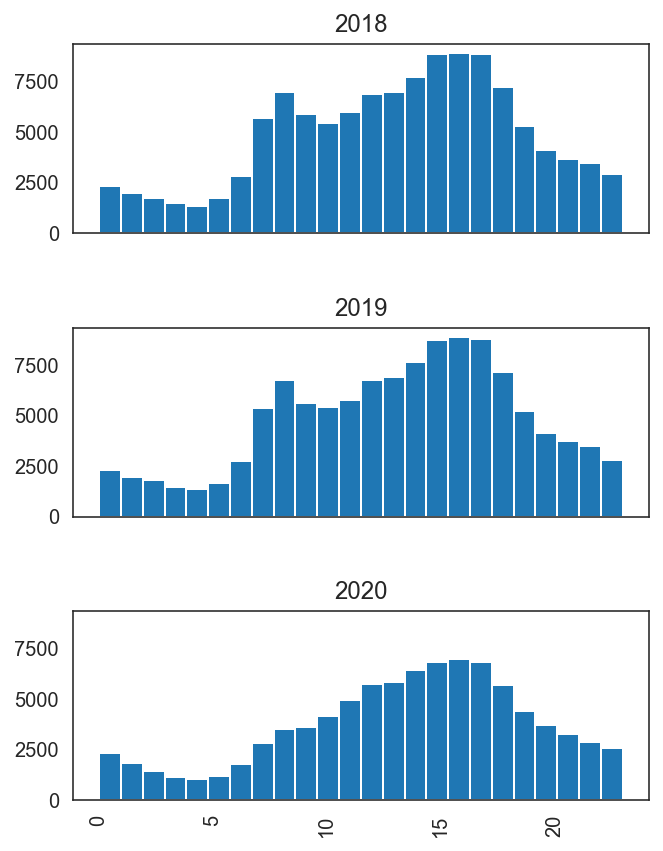

In [25]:
# Crashes
crash_df.hist('crash_hour',bins=24,by='crash_year',layout=(3,1),figsize=(5,7),sharey=True,sharex=True);

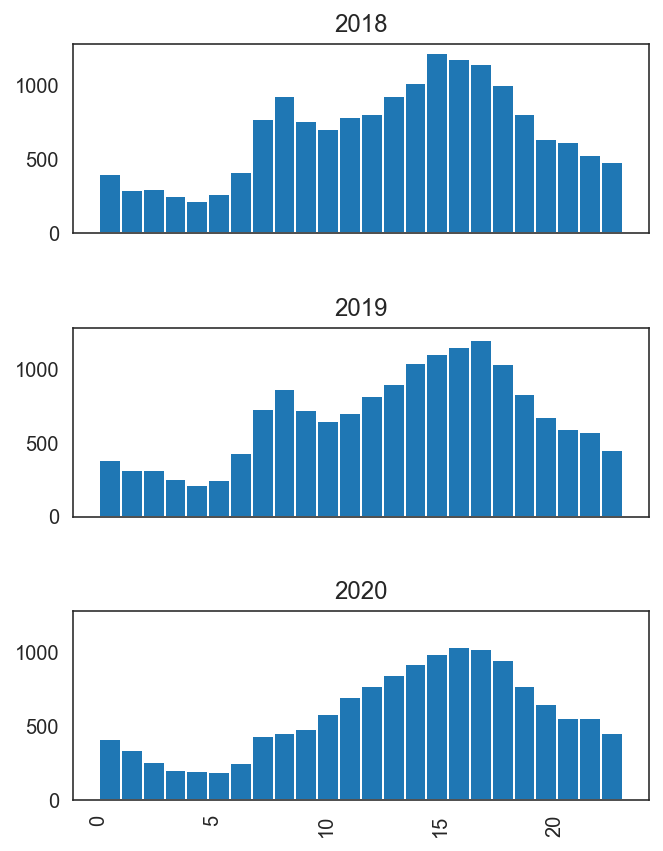

In [26]:
# Crahes that has injuries
crash_df.query('has_injuries == 1').hist('crash_hour',bins=24,by='crash_year',layout=(3,1),figsize=(5,7),sharey=True,sharex=True);

In [27]:
z = pd.cut(crash_df.crash_hour, bins=[-np.inf,6,12,18,np.inf], labels=['overnight','morning','mid_day','evening'])

In [28]:
z

0           mid_day
2           morning
3         overnight
5           evening
6           mid_day
            ...    
481571      morning
481572      morning
481573      morning
481574      mid_day
481575      mid_day
Name: crash_hour, Length: 326428, dtype: category
Categories (4, object): ['overnight' < 'morning' < 'mid_day' < 'evening']

In [29]:
z.value_counts()

mid_day      135306
morning       97562
evening       55797
overnight     37763
Name: crash_hour, dtype: int64

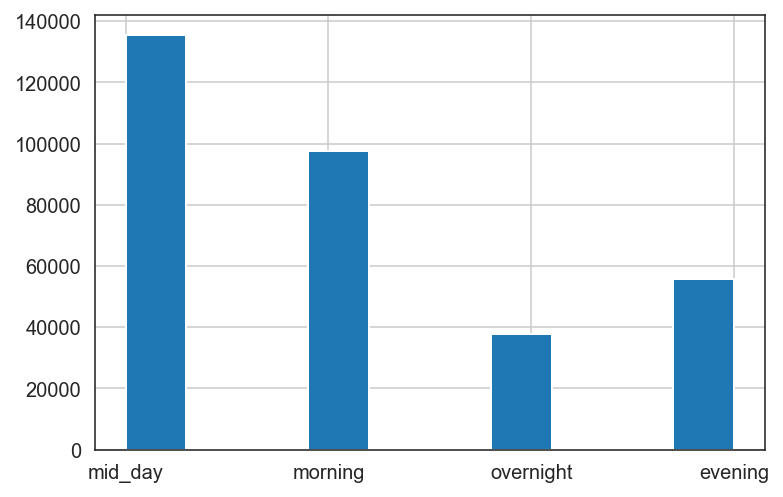

In [30]:
z.hist();

In [31]:
crash_df.crash_hour.isna().sum()

0

In [32]:
z.isna().sum()

0

In [33]:
crash_df.crash_hour.describe()

count   326,428.00
mean         13.20
std           5.55
min           0.00
25%           9.00
50%          14.00
75%          17.00
max          23.00
Name: crash_hour, dtype: float64

# Analaysis

Let's try out some aggreggations

In [34]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
    'crash_hour',
#    'weather_condition'
]).agg({
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index()
crash_agg

crash_year  crash_month  crash_hour  injuries_total  injuries_fatal
0          2018            1           0              31               0
1          2018            1           1              21               3
2          2018            1           2              35               4
3          2018            1           3              27               0
4          2018            1           4              20               0
..          ...          ...         ...             ...             ...
859        2020           12          19              81               0
860        2020           12          20              62               4
861        2020           12          21              68               0
862        2020           12          22              42               0
863        2020           12          23              48               2

[864 rows x 5 columns]

In [35]:
crash_agg.pivot_table(index=['crash_month'],columns='crash_year',values=['injuries_total','injuries_fatal'],aggfunc='sum')

injuries_fatal           injuries_total            
crash_year            2018 2019 2020           2018  2019  2020
crash_month                                                    
1                       11   11    7           1777  1500  1631
2                        6    4   10           1287  1404  1645
3                       11    9    3           1639  1706  1413
4                       11    6   11           1776  1756   893
5                        7    9   12           2144  2125  1405
6                       11   11   15           2003  2107  1831
7                       21    8   22           2155  2119  2128
8                       13   14   11           2034  2115  2106
9                        9   11   18           1948  1948  1873
10                      13    8   20           2028  2057  1839
11                       5   10    9           1731  1829  1474
12                       9    5   15           1905  1613  1374

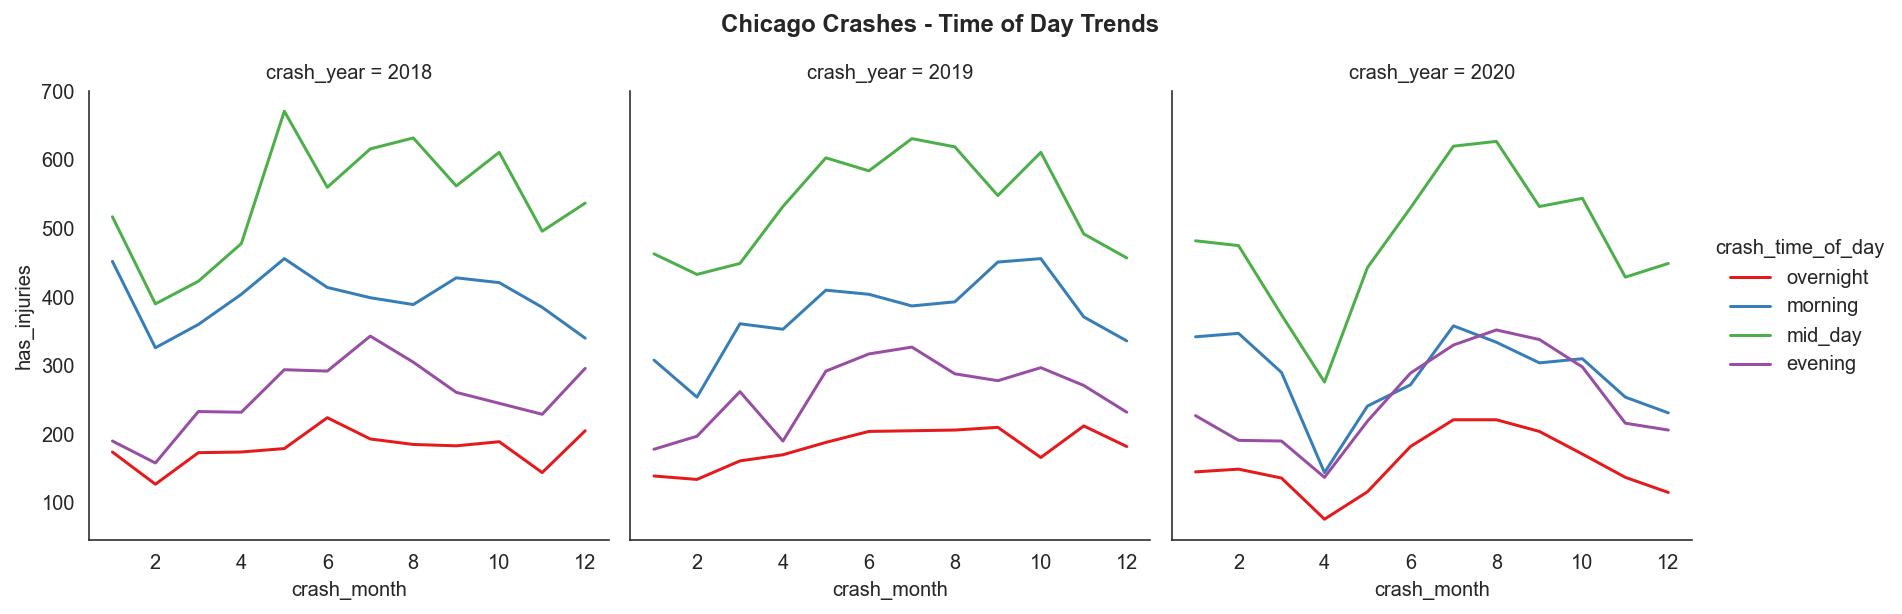

In [36]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
#    'crash_hour',
    'crash_time_of_day',
#    'weather_condition'
]).agg({
    'has_injuries':np.sum,
    'has_fatal':np.sum,
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index()

g = sns.FacetGrid(crash_agg, col='crash_year', hue='crash_time_of_day', palette='Set1', col_wrap=3, height=4)
g.map_dataframe(sns.lineplot,'crash_month', 'has_injuries')
g.fig.suptitle('Chicago Crashes - Time of Day Trends', y=1.05, fontweight='bold')
g.add_legend();

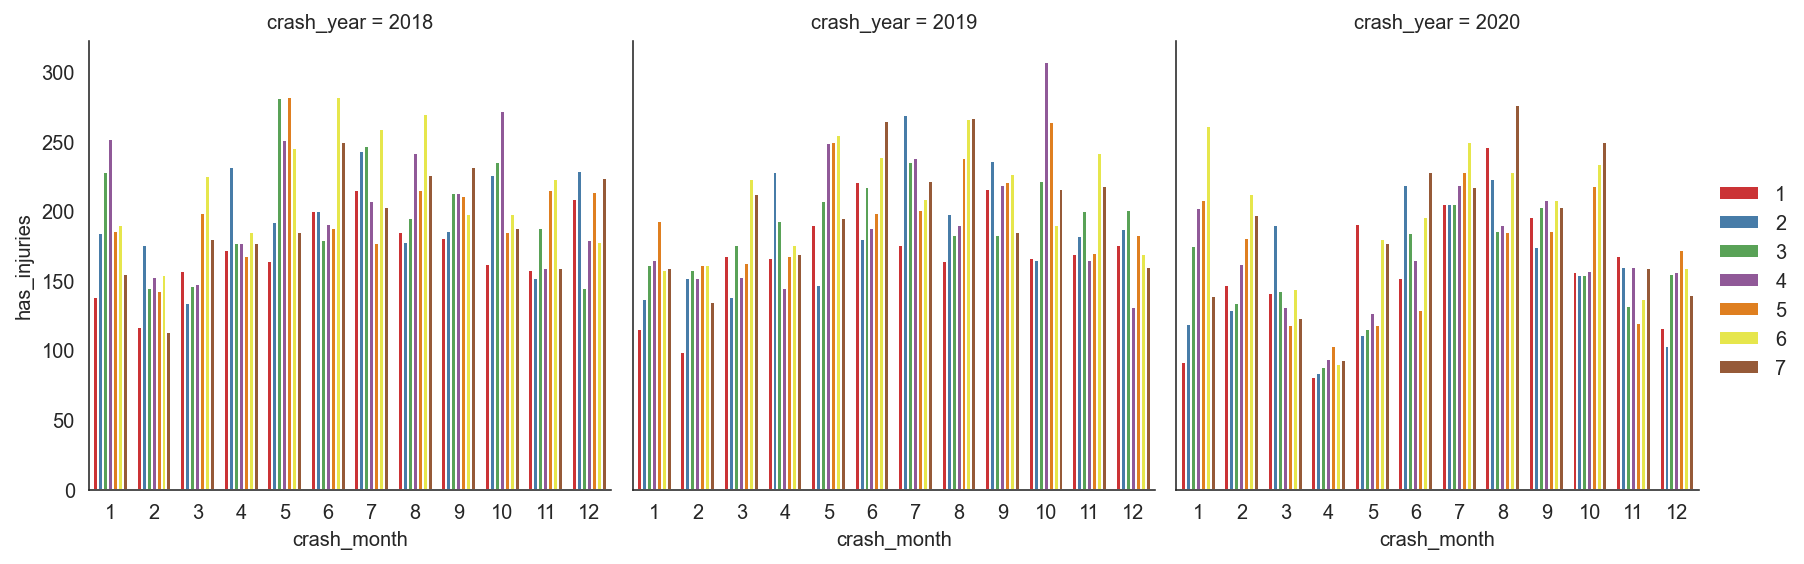

In [37]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
    'crash_day_of_week',
#    'crash_hour',
#    'weather_condition'
]).agg({
    'has_injuries':np.sum,
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index()

g = sns.FacetGrid(crash_agg, col='crash_year',  col_wrap=3, height=4)
g.map_dataframe(sns.barplot,'crash_month','has_injuries',hue='crash_day_of_week',palette='Set1',)
g.add_legend();

In [38]:
(crash_df.weather_condition == 'OTHER').sum()

1071

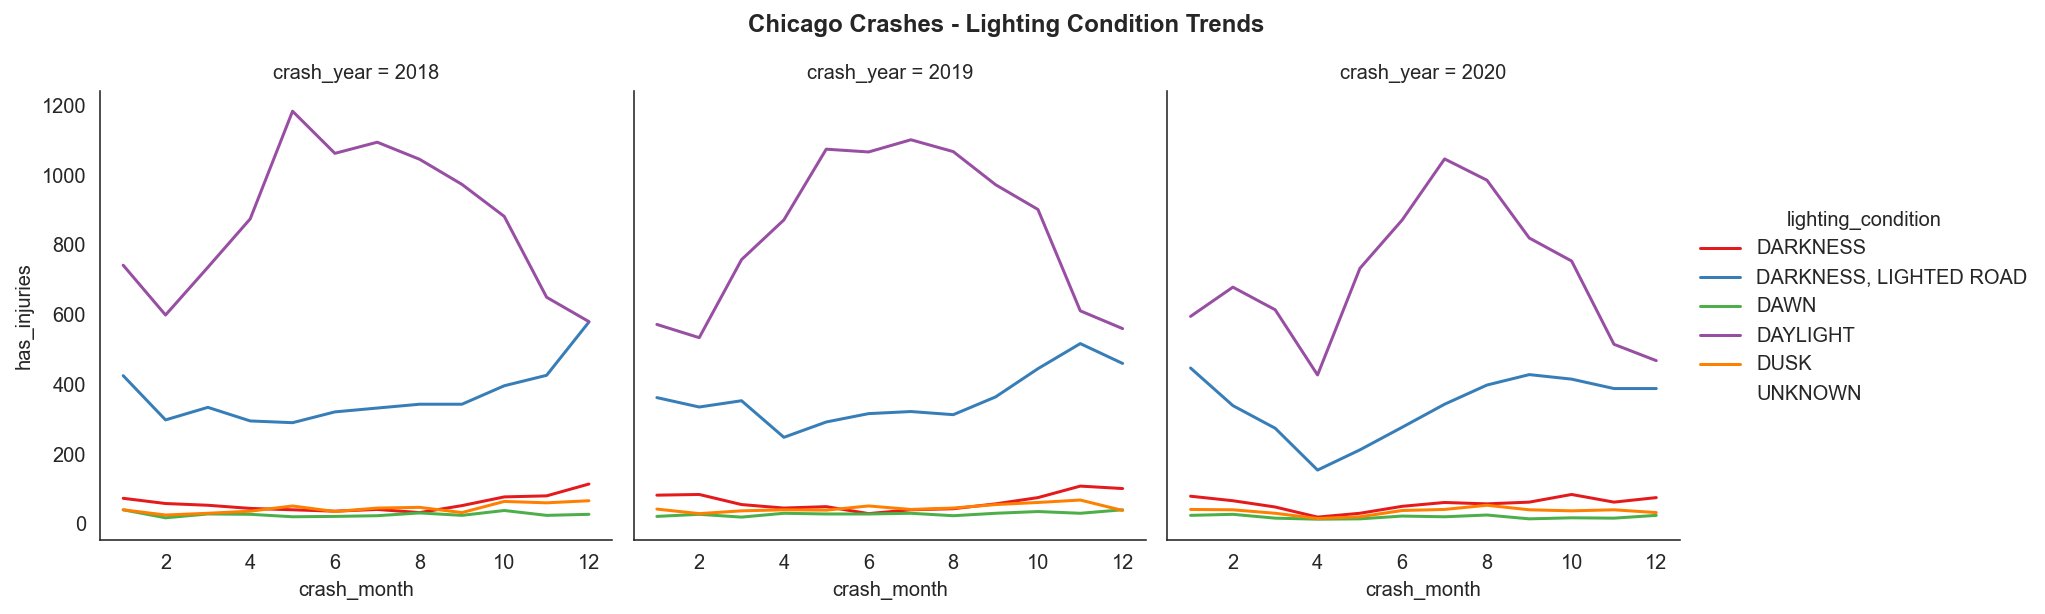

In [39]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
#    'crash_hour',
    'lighting_condition'
]).agg({
    'has_injuries':np.sum,
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index().query('lighting_condition not in ["UNKNOWN"]')

g = sns.FacetGrid(crash_agg, col='crash_year', hue='lighting_condition', palette='Set1', col_wrap=3, height=4)
g.map_dataframe(sns.lineplot,'crash_month', 'has_injuries')
g.fig.suptitle('Chicago Crashes - Lighting Condition Trends', y=1.05, fontweight='bold')
g.add_legend();

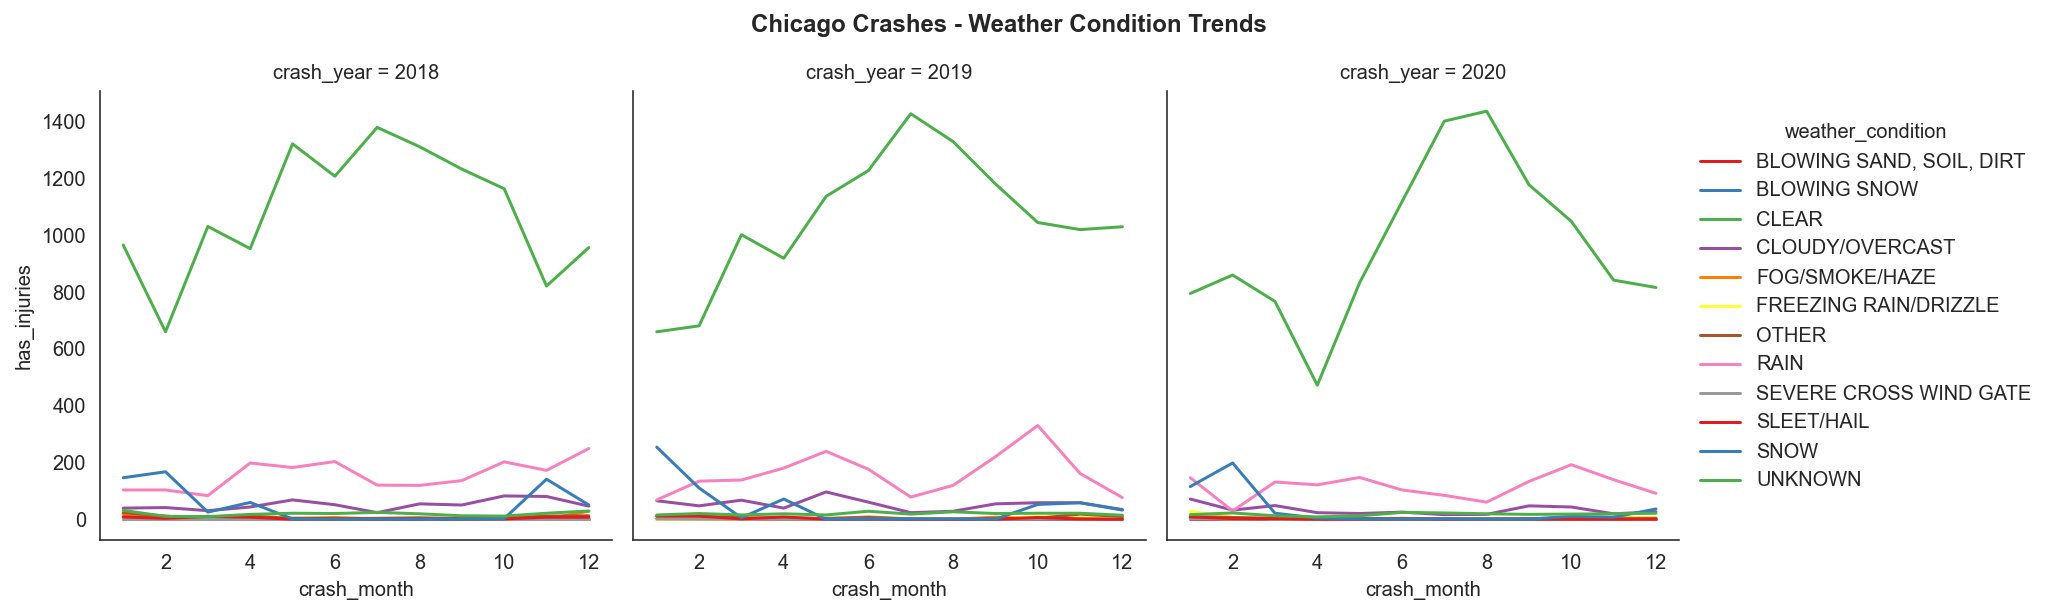

In [40]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
#    'crash_hour',
    'weather_condition'
]).agg({
    'has_injuries':np.sum,
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index()#.query('weather_condition not in ["CLEAR"]')

g = sns.FacetGrid(crash_agg, col='crash_year', hue='weather_condition', palette='Set1', col_wrap=3, height=4)
g.map_dataframe(sns.lineplot,'crash_month', 'has_injuries')
g.fig.suptitle('Chicago Crashes - Weather Condition Trends', y=1.05, fontweight='bold')
g.add_legend();

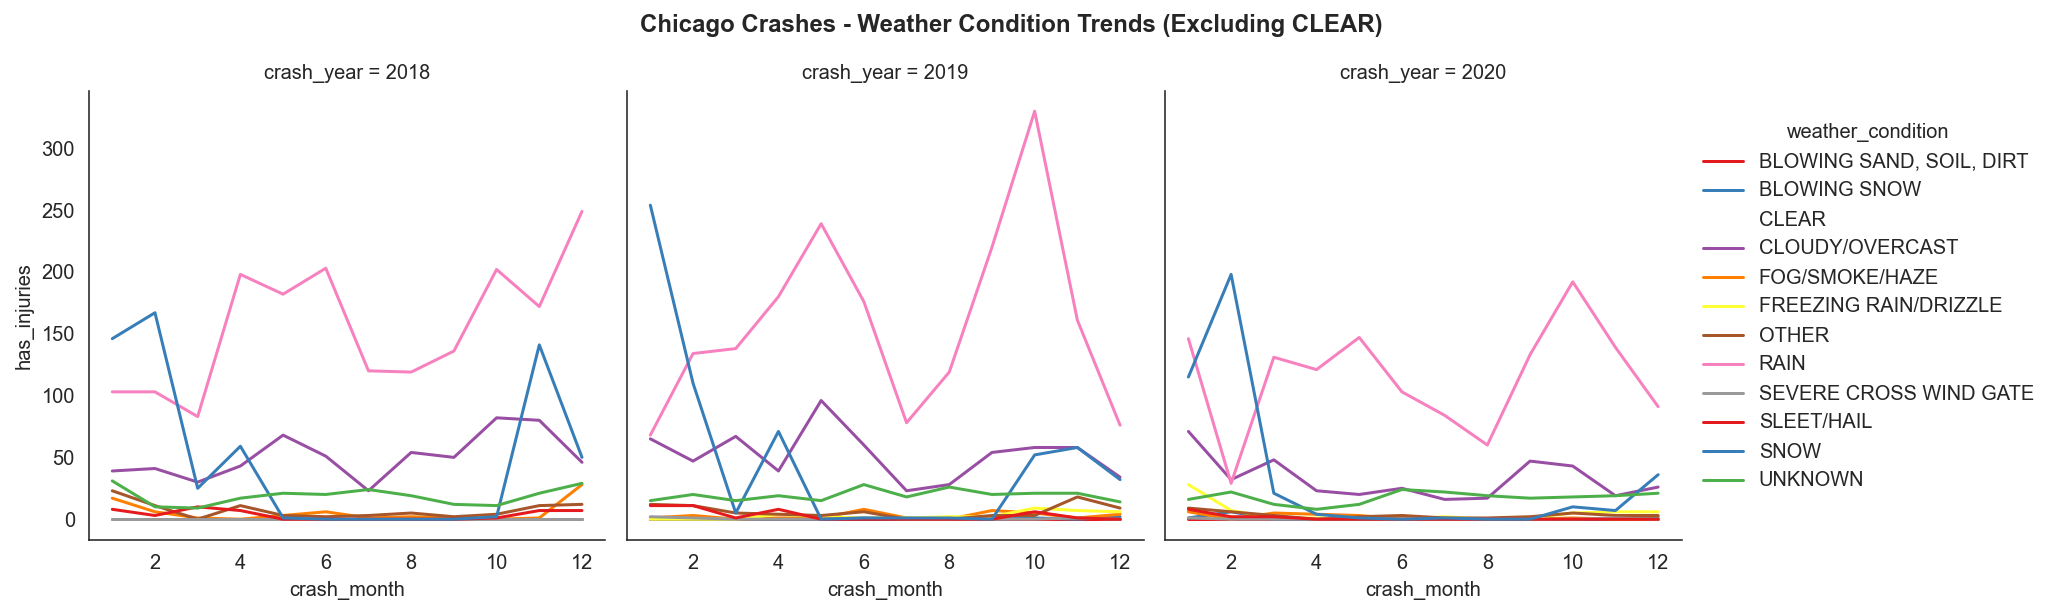

In [41]:
crash_agg = crash_df.groupby([
    'crash_year',
    'crash_month',
#    'crash_day_of_week',
#    'crash_hour',
    'weather_condition'
]).agg({
    'has_injuries':np.sum,
    'injuries_total':np.sum,
    'injuries_fatal':np.sum
}
).fillna(0).reset_index().query('weather_condition not in ["CLEAR"]')

g = sns.FacetGrid(crash_agg, col='crash_year', hue='weather_condition', palette='Set1', col_wrap=3, height=4)
g.map_dataframe(sns.lineplot,'crash_month', 'has_injuries')
g.fig.suptitle('Chicago Crashes - Weather Condition Trends (Excluding CLEAR)', y=1.05, fontweight='bold')
g.add_legend();

In [42]:
from sklearn.preprocessing import StandardScaler
crash_sdf = crash_df.copy()
col_names = ['injuries_total', 'injuries_fatal']
features = crash_sdf[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
crash_sdf[col_names] = features
display(crash_sdf.head(5))

crash_date  crash_year  crash_month  crash_day_of_week  crash_hour crash_time_of_day  latitude  longitude  \
0 2019-07-10 17:56:00        2019            7                  4          17           mid_day     41.92     -87.77   
2 2020-07-10 10:25:00        2020            7                  6          10           morning     41.77     -87.59   
3 2020-07-11 01:00:00        2020            7                  7           1         overnight     41.80     -87.62   
5 2019-03-21 22:50:00        2019            3                  5          22           evening     41.74     -87.74   
6 2018-03-26 14:23:00        2018            3                  2          14           mid_day     41.95     -87.73   

   beat_of_occurrence              address  posted_speed_limit traffic_control_device      device_condition  \
0                2515   2158 N MARMORA AVE                  35            NO CONTROLS           NO CONTROLS   
2                 331       1632 E 67TH ST                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
3                 224        110 E 51ST ST                  30            NO CONTROLS           NO CONTROLS   
5                 834    8301 S CICERO AVE                  30         TRAFFIC SIGNAL  FUNCTIONING PROPERLY   
6                1732  3999 N AVONDALE AVE                  35            NO CONTROLS           NO CONTROLS   

  weather_condition      lighting_condition                  trafficway_type           alignment roadway_surface_cond  \
0             CLEAR                DAYLIGHT                          ONE-WAY  STRAIGHT AND LEVEL                  DRY   
2             CLEAR                DAYLIGHT                         FOUR WAY  STRAIGHT AND LEVEL                  DRY   
3             CLEAR                DARKNESS  DIVIDED - W/MEDIAN (NOT RAISED)  STRAIGHT AND LEVEL                  DRY   
5             CLEAR  DARKNESS, LIGHTED ROAD                      NOT DIVIDED  STRAIGHT AND LEVEL                  DRY   
6             CLEAR                DAYLIGHT                      NOT DIVIDED  STRAIGHT AND LEVEL                  DRY   

  road_defect      first_crash_type        prim_contributory_cause         sec_contributory_cause  num_units  \
0  NO DEFECTS               TURNING               IMPROPER BACKING            UNABLE TO DETERMINE          2   
2  NO DEFECTS              REAR END  FAILING TO YIELD RIGHT-OF-WAY  FAILING TO YIELD RIGHT-OF-WAY          3   
3  NO DEFECTS  PARKED MOTOR VEHICLE            UNABLE TO DETERMINE            UNABLE TO DETERMINE          2   
5  NO DEFECTS               TURNING            UNABLE TO DETERMINE            UNABLE TO DETERMINE          2   
6  NO DEFECTS  PARKED MOTOR VEHICLE            UNABLE TO DETERMINE            UNABLE TO DETERMINE          2   

   has_injuries  has_fatal              crash_type         damage  injuries_total  injuries_fatal  
0             0          0  NO INJURY / DRIVE AWAY    OVER $1,500           -0.34           -0.03  
2             0          0  NO INJURY / DRIVE AWAY    OVER $1,500           -0.34           -0.03  
3             0          0  NO INJURY / DRIVE AWAY   $500 OR LESS           -0.34           -0.03  
5             0          0  NO INJURY / DRIVE AWAY    OVER $1,500           -0.34           -0.03  
6             0          0  NO INJURY / DRIVE AWAY  $501 - $1,500           -0.34           -0.03

/usr/local/Caskroom/miniconda/base/envs/depaul/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


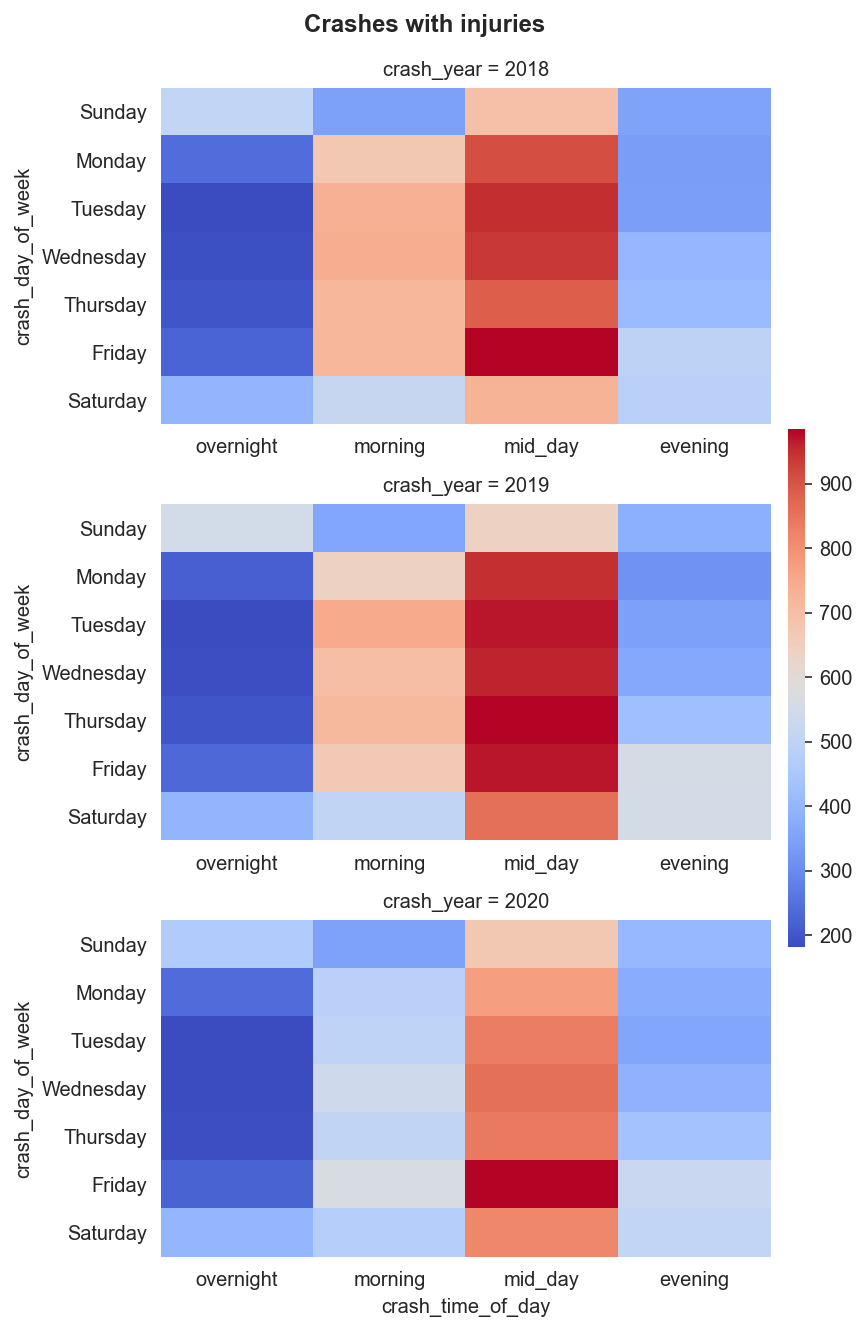

In [43]:
            
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot_table(index=args[1], columns=args[0], values=args[2], aggfunc=sum)
    ax = sns.heatmap(d, **kwargs, cmap='coolwarm')
    ax.set_yticklabels(week_days.values(),rotation=0)
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

fg = sns.FacetGrid(crash_df, row='crash_year', aspect=2, sharex=False)
cbar_ax = fg.fig.add_axes([.92, .3, .02, .4],)  # <-- Create a colorbar axes
fg.map_dataframe(draw_heatmap, 'crash_time_of_day', 'crash_day_of_week', 'has_injuries', square = False,
                 cbar_ax=cbar_ax,
                 #vmin=0, vmax=1, center=.5
                )
fg.fig.subplots_adjust(right=.9)
fg.fig.suptitle('Crashes with injuries', y=1.02, fontweight='bold')
plt.show()

# Fiddling with Weekends

In [44]:
crash_df.query('crash_day_of_week == 1').crash_date.dt.day_name()[:1]

45    Sunday
Name: crash_date, dtype: object

In [45]:
crash_df.crash_day_of_week.map(lambda x: 'Weekend' if x in [1,7] else 'Weekday')

0         Weekday
2         Weekday
3         Weekend
5         Weekday
6         Weekday
           ...   
481571    Weekday
481572    Weekend
481573    Weekday
481574    Weekday
481575    Weekday
Name: crash_day_of_week, Length: 326428, dtype: object

/usr/local/Caskroom/miniconda/base/envs/depaul/lib/python3.9/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


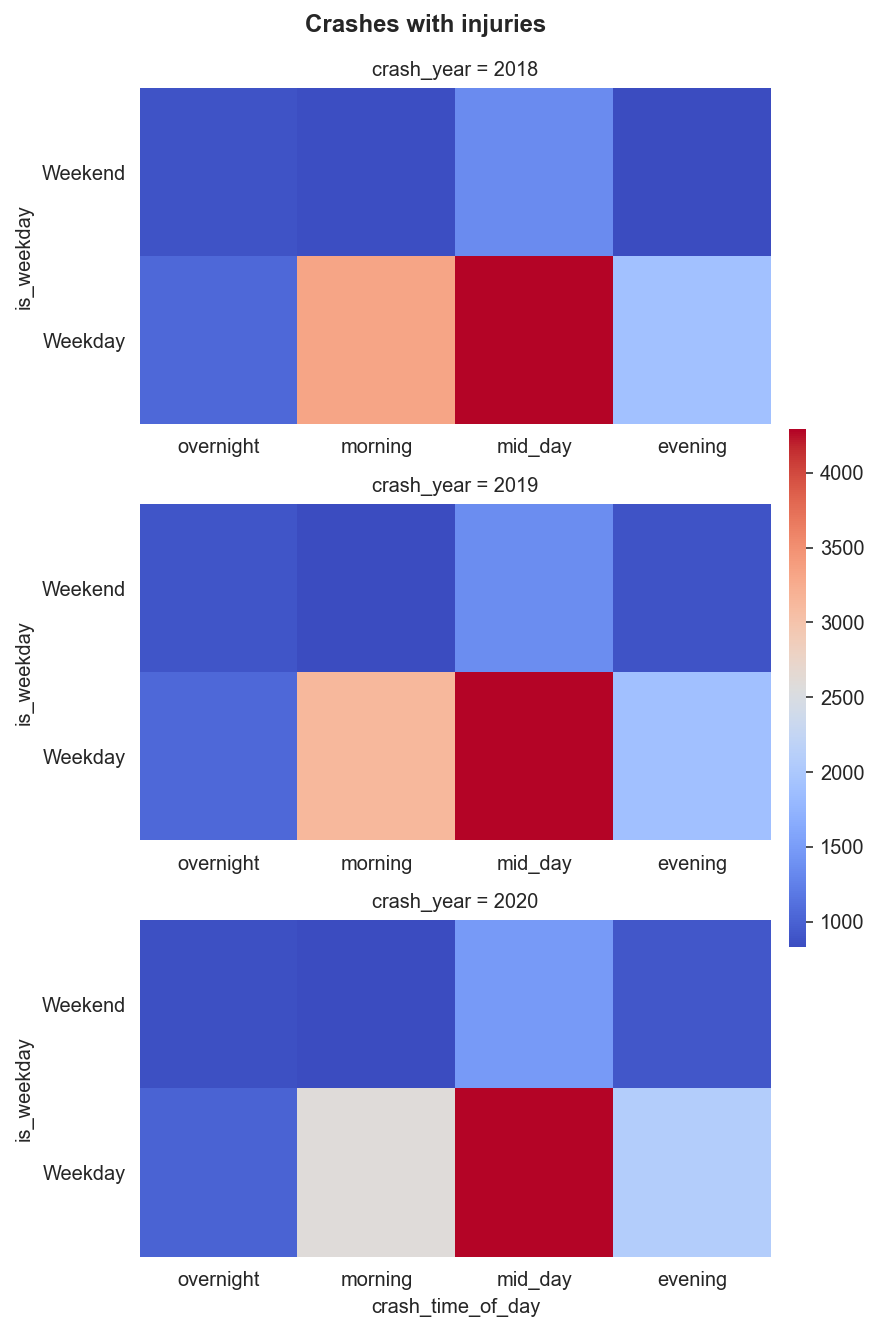

In [46]:
def draw_heatmap(*args, **kwargs):
    data = kwargs.pop('data')
    d = data.pivot_table(index=args[1], columns=args[0], values=args[2], aggfunc=sum)
    ax = sns.heatmap(d, **kwargs, cmap='coolwarm')
    ax.set_yticklabels(is_weekday.values(),rotation=0)
    #ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
_ = crash_df
_['is_weekday'] = crash_df.crash_day_of_week.map(lambda x: 0 if x in [1,7] else 1)

fg = sns.FacetGrid(_, row='crash_year',  aspect=2, sharex=False)
cbar_ax = fg.fig.add_axes([.92, .3, .02, .4],)  # <-- Create a colorbar axes
fg.map_dataframe(draw_heatmap, 'crash_time_of_day', 'is_weekday', 'has_injuries', square = False,
                 cbar_ax=cbar_ax,
                 #vmin=0, vmax=1, center=.5
                )
fg.fig.subplots_adjust(right=.9)
fg.fig.suptitle('Crashes with injuries', y=1.02, fontweight='bold')
plt.show()

# Plot Map

In [47]:
crash_df.groupby(by=['longitude','latitude']).size().reset_index(name='crashes')

longitude  latitude  crashes
0          -87.93     41.96        1
1          -87.93     41.96        1
2          -87.93     41.96       23
3          -87.93     42.01        1
4          -87.93     41.96        4
...           ...       ...      ...
162700     -87.52     41.70        1
162701     -87.52     41.70        5
162702     -87.52     41.70        1
162703     -87.52     41.70        2
162704     -87.52     41.70        6

[162705 rows x 3 columns]

In [48]:
crash_df_ = crash_df.copy()
#crash_df_['crash_year'] = crash_df_['crash_year'].astype('category')
#crash_df_['longitude'] = crash_df_['longitude'].round(4)
#crash_df_['latitude'] = crash_df_['latitude'].round(4)
crash_df_ = crash_df_.groupby(by=['longitude','latitude','crash_year']).agg(crashes=('has_injuries', 'count'), has_injuries=('has_injuries', 'max'), is_weekday=('is_weekday', 'max')).reset_index().query('crashes > 0')

In [49]:
crash_df_

longitude  latitude  crash_year  crashes  has_injuries  is_weekday
0          -87.93     41.96        2020        1             0           1
1          -87.93     41.96        2019        1             0           1
2          -87.93     41.96        2019        8             1           1
3          -87.93     41.96        2020       15             1           1
4          -87.93     42.01        2019        1             1           0
...           ...       ...         ...      ...           ...         ...
212873     -87.52     41.70        2020        2             0           1
212874     -87.52     41.70        2019        1             0           1
212875     -87.52     41.70        2020        2             0           0
212876     -87.52     41.70        2019        2             1           1
212877     -87.52     41.70        2020        4             0           1

[212878 rows x 6 columns]

In [50]:
crash_df_.query('crashes>5')

longitude  latitude  crash_year  crashes  has_injuries  is_weekday
2          -87.93     41.96        2019        8             1           1
3          -87.93     41.96        2020       15             1           1
15         -87.91     41.95        2019        8             1           1
16         -87.91     41.95        2020       14             1           1
21         -87.91     41.98        2018      111             1           1
...           ...       ...         ...      ...           ...         ...
212811     -87.53     41.70        2019        7             1           1
212838     -87.53     41.70        2018       10             0           1
212840     -87.53     41.70        2020        7             0           1
212856     -87.53     41.70        2018        7             0           1
212857     -87.53     41.70        2019        7             0           1

[5439 rows x 6 columns]

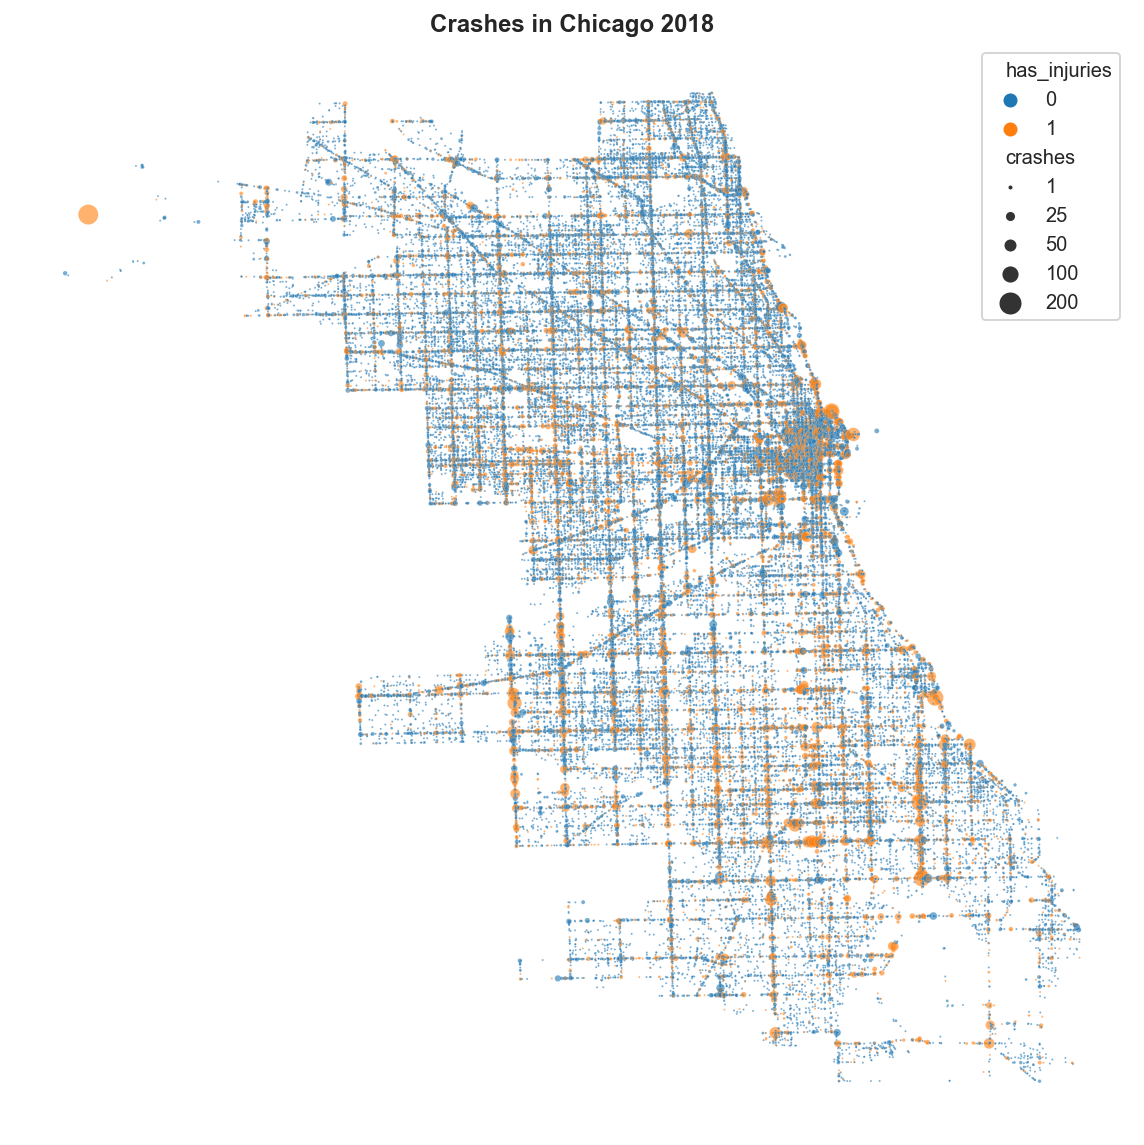

In [58]:
plt.subplots(figsize=(10,10))
fg = sns.scatterplot(data=crash_df_.query('crash_year == 2018'), x='longitude',y='latitude',
                hue='has_injuries', sizes={1:1,25:12.5,50:25,100:50,200:100}, size_norm=(1,100), size='crashes', alpha=.6)
fg.set_axis_off()
fg.set_title('Crashes in Chicago 2018',fontweight='bold');

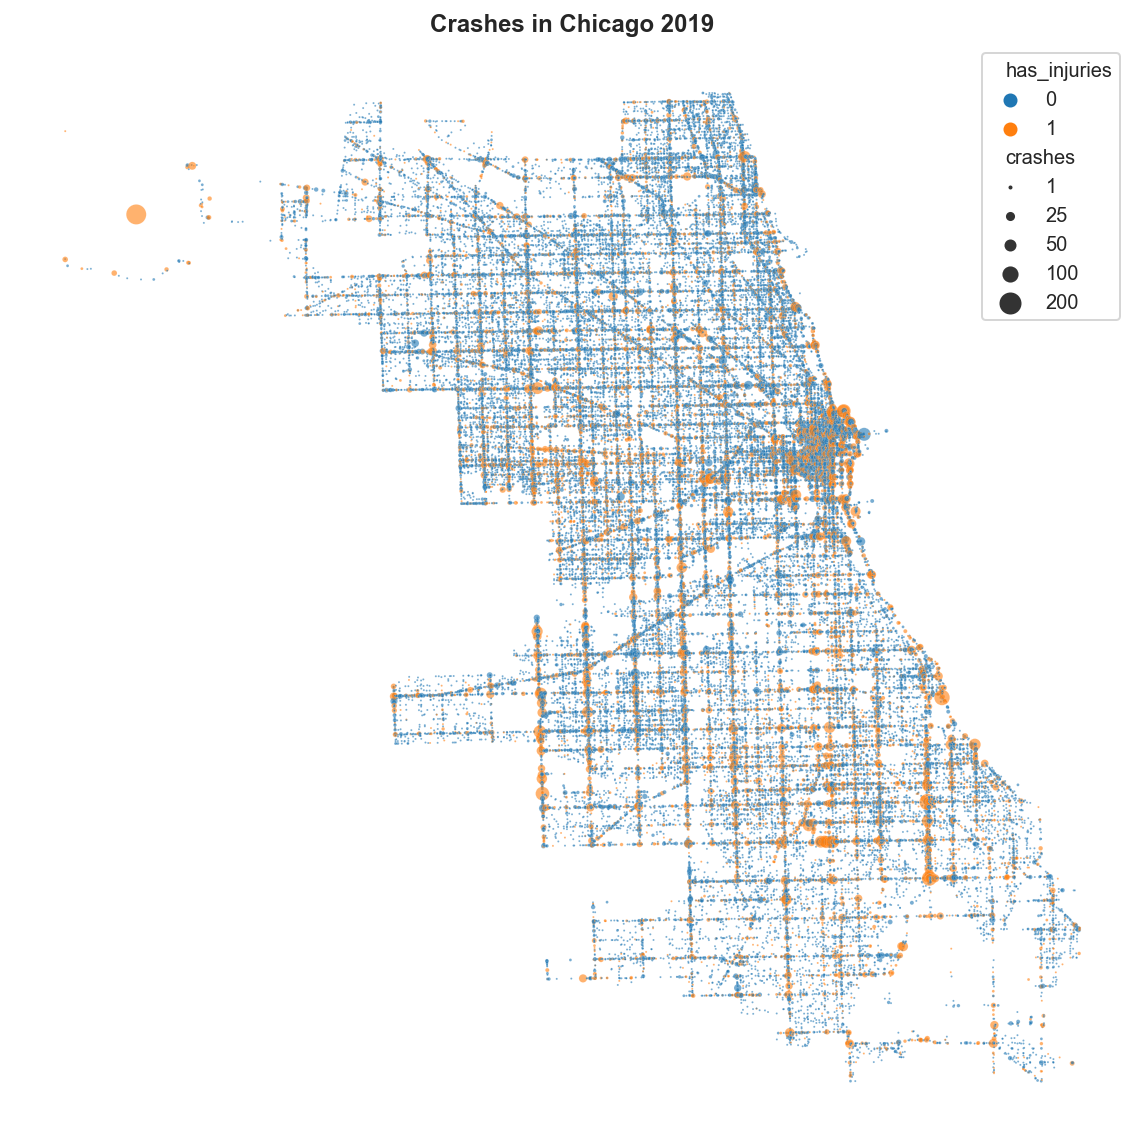

In [59]:
plt.subplots(figsize=(10,10))
fg = sns.scatterplot(data=crash_df_.query('crash_year == 2019'), x='longitude',y='latitude',
                hue='has_injuries', sizes={1:1,25:12.5,50:25,100:50,200:100}, size_norm=(1,100), size='crashes', alpha=.6)
fg.set_axis_off()
fg.set_title('Crashes in Chicago 2019',fontweight='bold');

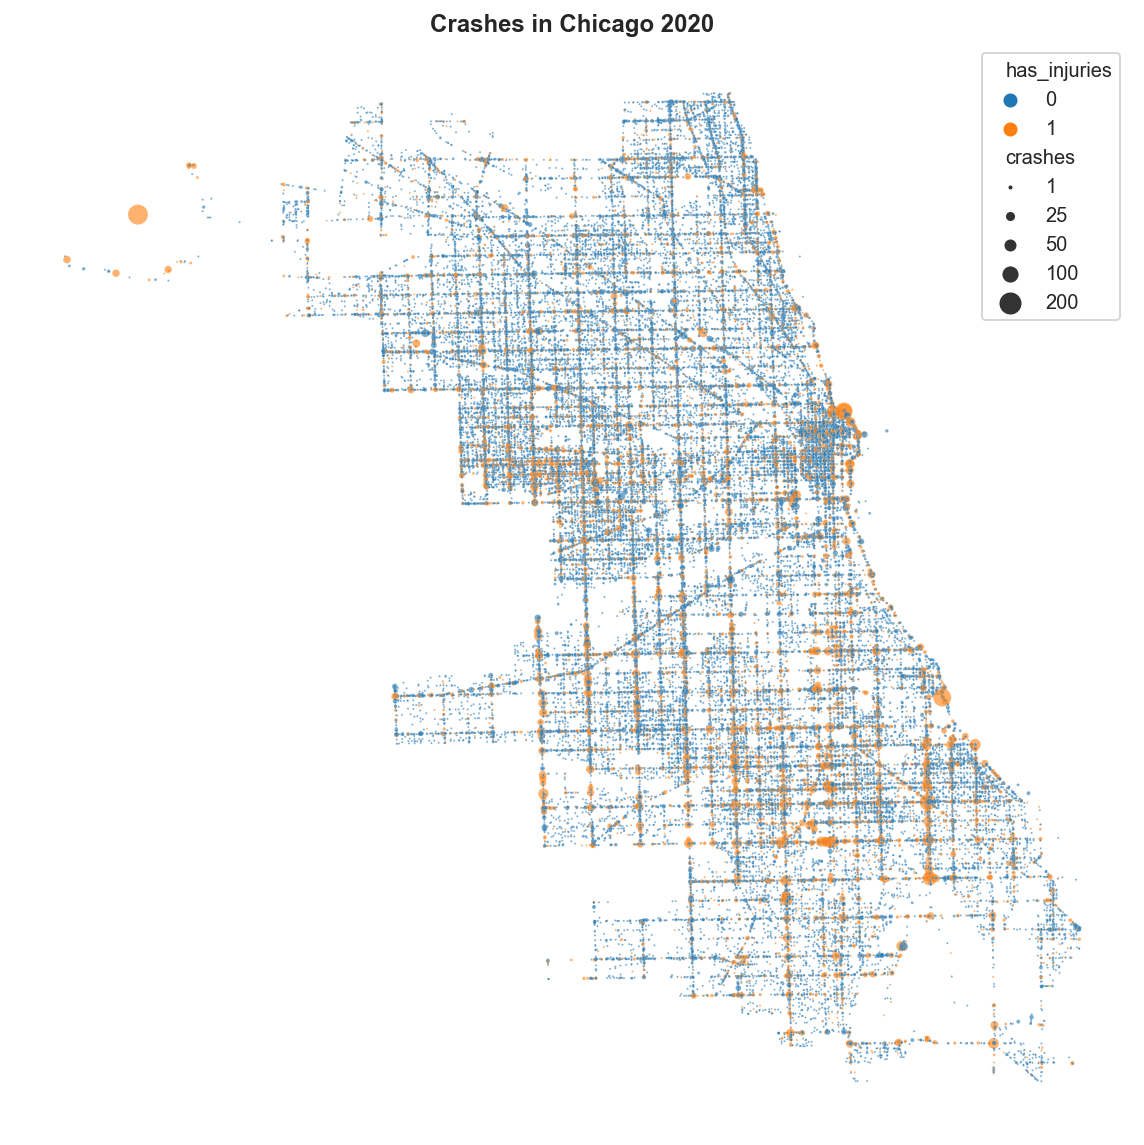

In [60]:
plt.subplots(figsize=(10,10))
fg = sns.scatterplot(data=crash_df_.query('crash_year == 2020'), x='longitude',y='latitude',
                hue='has_injuries', sizes={1:1,25:12.5,50:25,100:50,200:100}, size_norm=(1,100), size='crashes', alpha=.6)
fg.set_axis_off()
fg.set_title('Crashes in Chicago 2020',fontweight='bold');

in 2020 we can see shift in crash sites having injuries away from downtown

In [54]:
#from matplotlib import colors
#cmap = colors.ListedColormap(['green', 'yellow', 'red'])
#cmap

# Next steps for modeling

![](https://scikit-learn.org/stable/_static/ml_map.png)